In [1]:
import pandas as pd
import time

from importlib import reload
import dmd
reload(dmd)
from dmd import *

Nx = 401
Nt = 10000
dx = 1/(Nx-1)
dt=1e-8
x = np.linspace(0, 1, Nx)

In [2]:
D1 = np.transpose(pd.read_csv('../1_Generate_Data/psi1.csv').astype(complex).values)
D2 = np.transpose(pd.read_csv('../1_Generate_Data/psi2.csv').astype(complex).values)
D3 = np.transpose(pd.read_csv('../1_Generate_Data/psi3.csv').astype(complex).values)
D4 = np.transpose(pd.read_csv('../1_Generate_Data/psi4.csv').astype(complex).values)

### Xk+1 vs. Xdot approach

### Xk+1

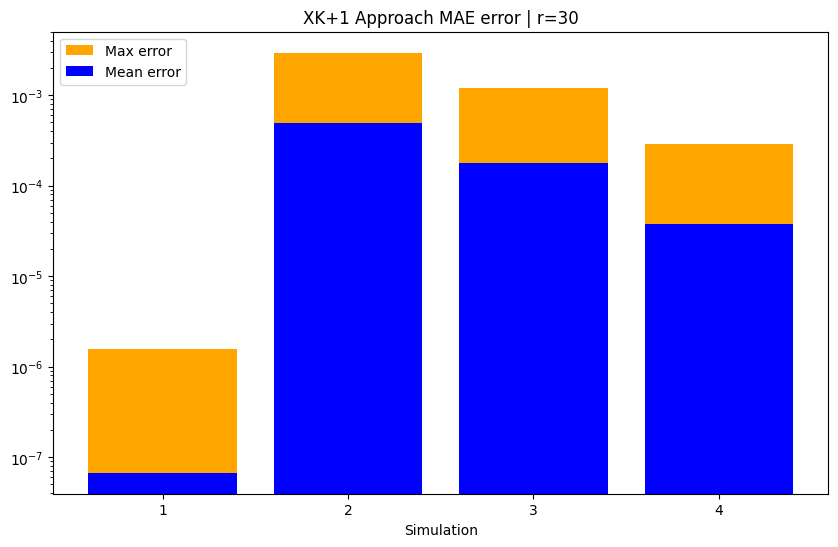

In [3]:
mae_values = []
max_values = []
for i_,D in enumerate([D1,D2,D3,D4]):
    i = i_+1

    X = D[:,:-1]
    Y = D[:,1:]

    A = DMD(X,Y,r=30)

    D_pred = np.zeros(shape=(Nx,Nt)).astype(complex)
    D_pred[:,0] = D[:,0]

    for t in range(1,Nt):
        Xt = D_pred[:,t-1].reshape(Nx,1)
        Xt1 = A @ Xt
        Xt1
        D_pred[:,t] = Xt1.flatten()
    
    mae = np.mean(np.abs(D_pred - D))
    max_error = np.max(np.abs(D_pred - D))
    mae_values.append(mae)
    max_values.append(max_error)

x = ['1','2','3','4']
plt.figure(figsize=(10,6))
plt.bar(x,max_values, label='Max error', color='orange',)
plt.bar(x,mae_values, label='Mean error', color='blue')
plt.yscale('log')
plt.xlabel('Simulation')
plt.legend(loc='upper left')
plt.title('XK+1 Approach MAE error | r=30')

plt.show()
    
    

### Xdot

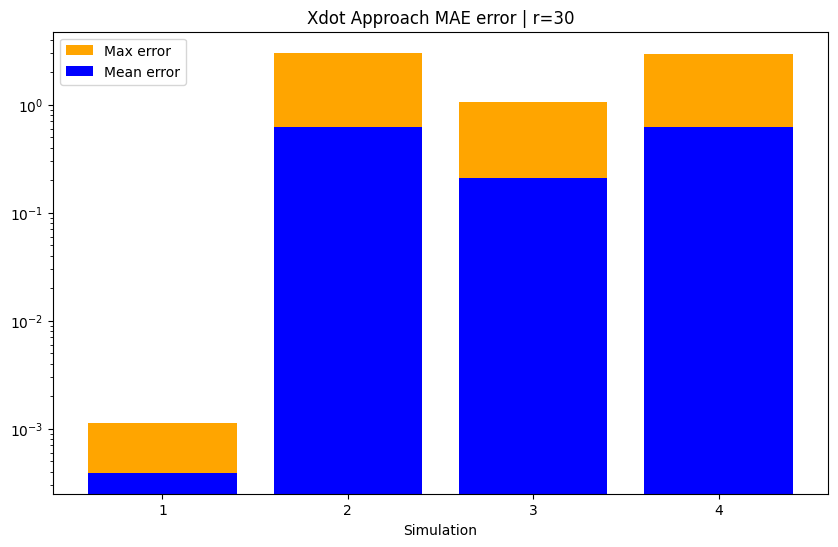

In [4]:
mae_values = []
max_values = []
for i_,D in enumerate([D1,D2,D3,D4]):
    i = i_+1

    X = D[:,:-1]
    Y = D[:,1:] - X

    A = DMD(X,Y,r=30)

    D_pred = np.zeros(shape=(Nx,Nt)).astype(complex)
    D_pred[:,0] = D[:,0]

    for t in range(1,Nt):
        Xt = D_pred[:,t-1].reshape(Nx,1)
        Xt1 = Xt + A @ Xt
        Xt1
        D_pred[:,t] = Xt1.flatten()
    
    mae = np.mean(np.abs(D_pred - D))
    max_error = np.max(np.abs(D_pred - D))
    mae_values.append(mae)
    max_values.append(max_error)

x = ['1','2','3','4']
plt.figure(figsize=(10,6))
plt.bar(x,max_values, label='Max error', color='orange',)
plt.bar(x,mae_values, label='Mean error', color='blue')
plt.yscale('log')
plt.xlabel('Simulation')
plt.legend(loc='upper left')
plt.title('Xdot Approach MAE error | r=30')
plt.show()

### Determine a good rank r for approximation

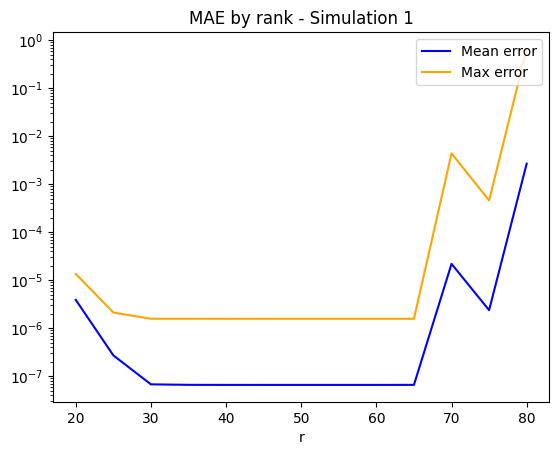

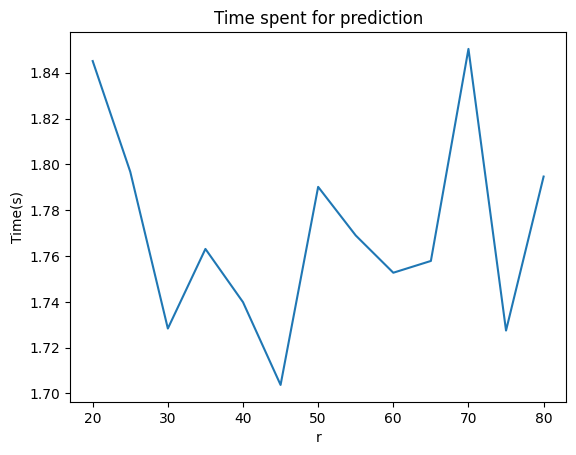

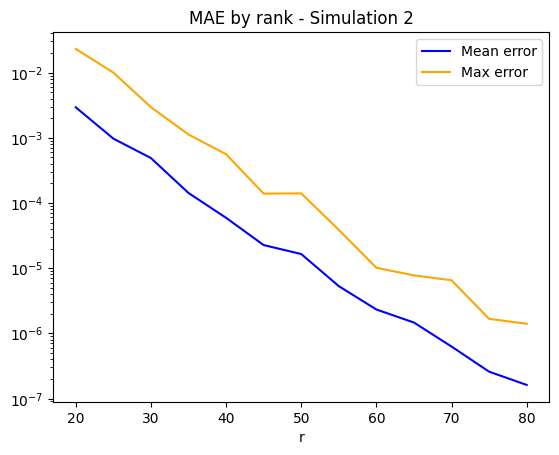

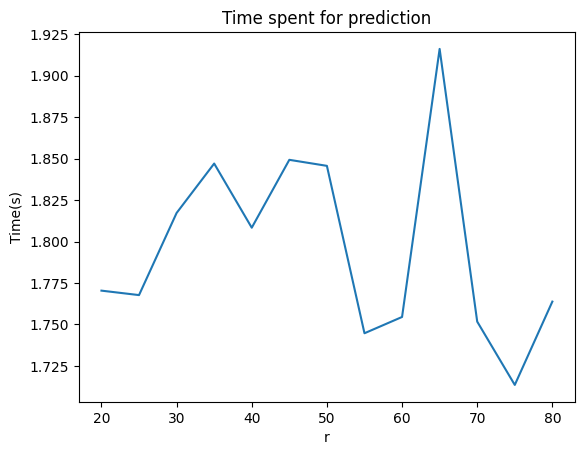

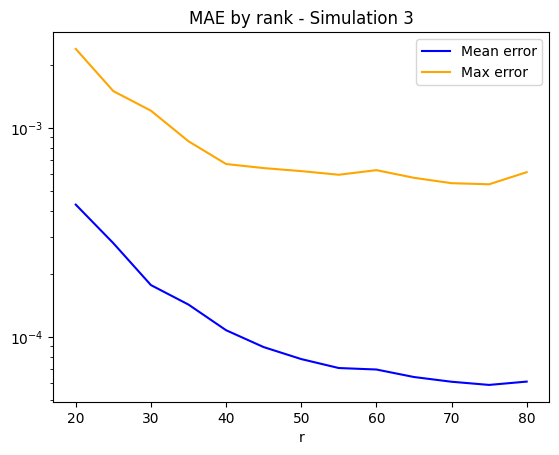

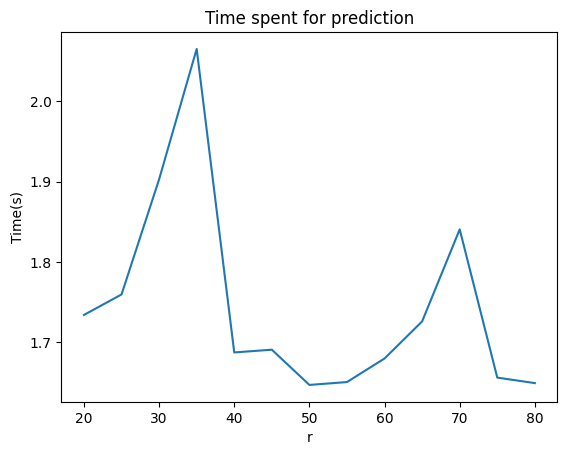

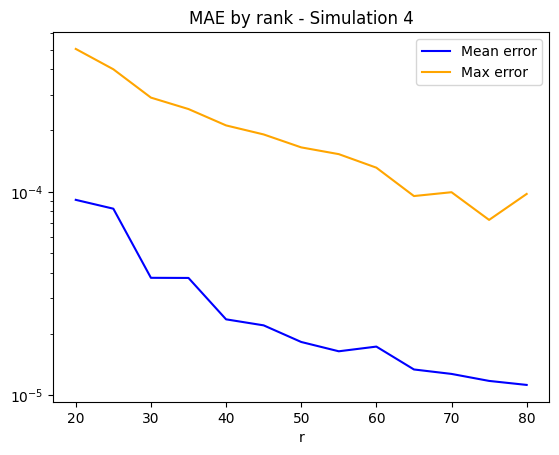

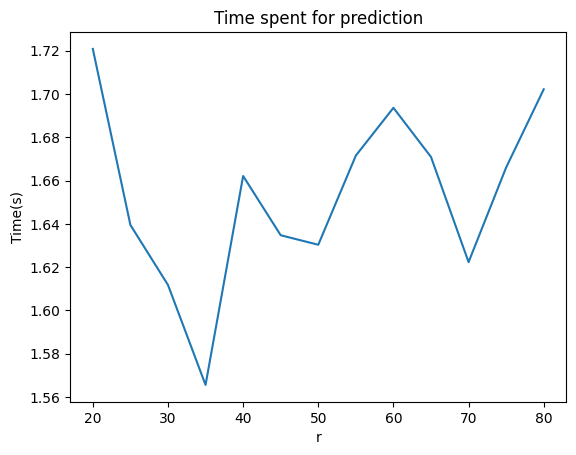

In [5]:
for i_,D in enumerate([D1,D2,D3,D4]):
    i = i_+1
    X = D[:,:-1]
    Y = D[:,1:]

    R = np.arange(20,85,5).astype(int)
    MAE = []
    MAX_ERROR = []
    T = []
    for r in R:
        #print(r)
        A = DMD(X, Y, r=r)

        start_time = time.time()

        D_pred = np.zeros(shape=(Nx,Nt)).astype(complex)
        D_pred[:,0] = D[:,0]

        for t in range(1,Nt):
            Xt = D_pred[:,t-1].reshape(Nx,1)
            Xt1 = A @ Xt
            Xt1
            D_pred[:,t] = Xt1.flatten()
        
        pred_time = time.time() - start_time
        mae = np.mean(np.abs(D_pred - D))
        max_error = np.max(np.abs(D_pred - D))

        T.append(pred_time)
        MAE.append(mae)
        MAX_ERROR.append(max_error)

    plt.plot(R,MAE,label='Mean error', color='blue')
    plt.plot(R,MAX_ERROR, label = 'Max error',color='orange')
    plt.yscale('log')
    plt.xlabel('r')
    plt.legend(loc='upper right')
    plt.title(f'MAE by rank - Simulation {i}')
    plt.show()

    plt.plot(R,T)
    plt.xlabel('r')
    plt.ylabel('Time(s)')
    plt.title('Time spent for prediction')
    plt.show()
    

### Check reconstruction

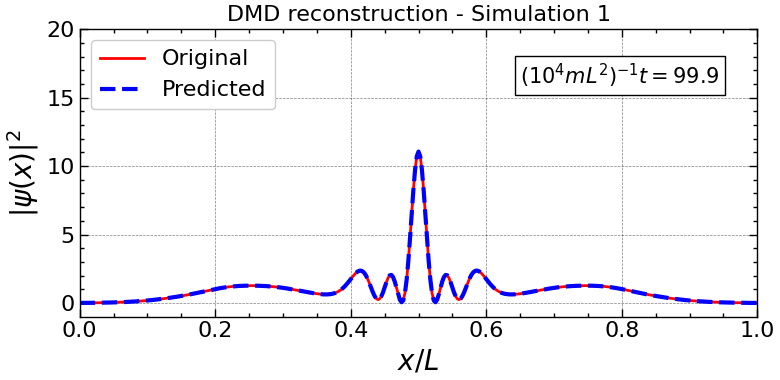

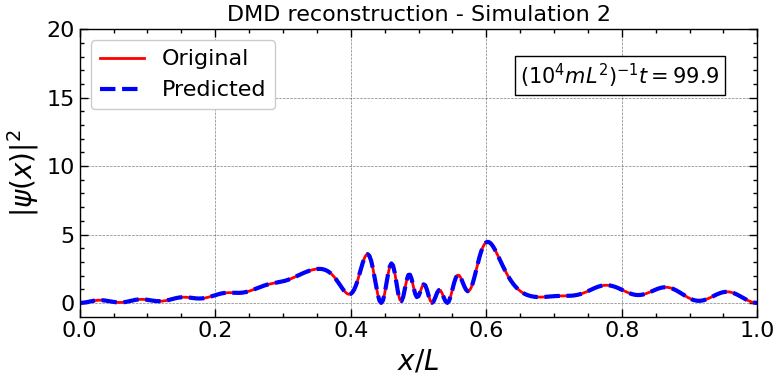

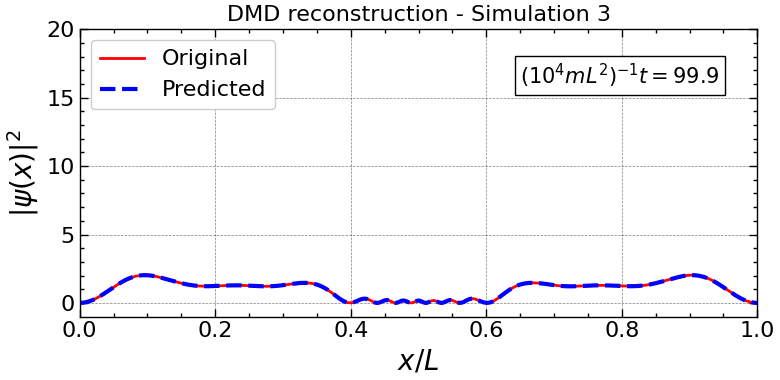

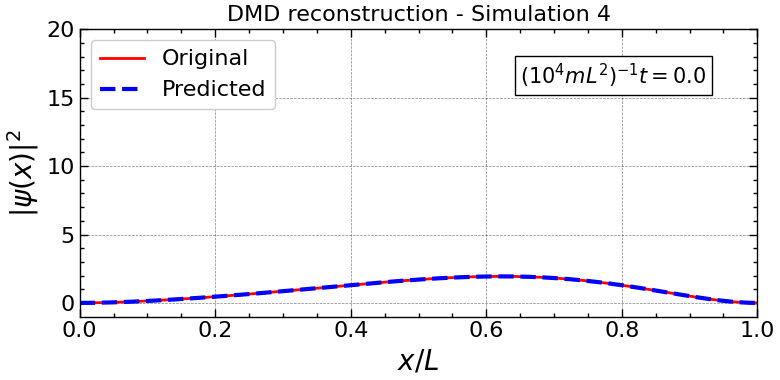

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
import scienceplots
from scipy.linalg import eigh_tridiagonal
plt.style.use(['science', 'notebook', 'grid'])

for i_,D in enumerate([D1,D2,D3,D4]):
    k = i_+1
    X = D[:,:-1]
    Y = D[:,1:]

    r = 60
    A = DMD(X, Y, r=r)
    x = np.linspace(0, 1, Nx)

    D_pred = np.zeros(shape=(Nx,Nt)).astype(complex)
    D_pred[:,0] = D[:,0]

    for t in range(1,Nt):
        Xt = D_pred[:,t-1].reshape(Nx,1)
        Xt1 = A @ Xt
        Xt1
        D_pred[:,t] = Xt1.flatten()

    def animate(i):
        ln1.set_data(x, np.absolute(np.transpose(D)[10*i])**2)
        ln2.set_data(x, np.absolute(np.transpose(D_pred)[10*i])**2)
        time_text.set_text('$(10^4 mL^2)^{-1}t=$'+'{:.1f}'.format(1000*i*dt*1e4))
    
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    #ax.grid()
    ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Original')
    ln2, = plt.plot([], [], 'b--', lw=3, markersize=8, label='Predicted')
    time_text = ax.text(0.65, 16, '', fontsize=15,
            bbox=dict(facecolor='white', edgecolor='black'))
    ax.set_ylim(-1, 20)
    ax.set_xlim(0,1)
    ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
    ax.set_xlabel('$x/L$', fontsize=20)
    ax.legend(loc='upper left')
    ax.set_title(f'DMD reconstruction - Simulation {k}')
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
    ani.save(f'reconstruction{k}.gif',writer='pillow',fps=50,dpi=100)

    

### Predict new experiments with data from the first

In [9]:
def test_all_data(A):

    D1_pred = np.zeros(shape=D1.shape).astype(complex)
    D1_pred[:,0] = D1[:,0]

    for t in range(1,Nt):
        Xt = D1_pred[:,t-1].reshape(Nx,1)
        Xt1 = A @ Xt
        Xt1
        D1_pred[:,t] = Xt1.flatten()

    mae1 = np.mean(np.abs(D1_pred - D1))
    max_error1 = np.max(np.abs(D1_pred - D1))

    D2_pred = np.zeros(shape=D1.shape).astype(complex)
    D2_pred[:,0] = D2[:,0]

    for t in range(1,Nt):
        Xt = D2_pred[:,t-1].reshape(Nx,1)
        Xt1 = A @ Xt
        Xt1
        D2_pred[:,t] = Xt1.flatten()

    mae2 = np.mean(np.abs(D2_pred - D2))
    max_error2 = np.max(np.abs(D2_pred - D2))

    D3_pred = np.zeros(shape=D1.shape).astype(complex)
    D3_pred[:,0] = D3[:,0]

    for t in range(1,Nt):
        Xt = D3_pred[:,t-1].reshape(Nx,1)
        Xt1 = A @ Xt
        Xt1
        D3_pred[:,t] = Xt1.flatten()

    mae3 = np.mean(np.abs(D3_pred - D3))
    max_error3 = np.max(np.abs(D3_pred - D3))

    D4_pred = np.zeros(shape=D1.shape).astype(complex)
    D4_pred[:,0] = D4[:,0]

    for t in range(1,Nt):
        Xt = D4_pred[:,t-1].reshape(Nx,1)
        Xt1 = A @ Xt
        Xt1
        D4_pred[:,t] = Xt1.flatten()

    mae4 = np.mean(np.abs(D4_pred - D4))
    max_error4 = np.max(np.abs(D4_pred - D4))

    mae_values = [mae1, mae2, mae3, mae4]
    max_values = [max_error1, max_error2, max_error3, max_error4]

    return mae_values, max_values

def plot_bar(mae_values, max_values, title):
    x = ['1','2','3','4']
    plt.figure(figsize=(10,6))
    plt.bar(x,max_values, label='Max error', color='orange',)
    plt.bar(x,mae_values, label='Mean error', color='blue')
    plt.yscale('log')
    plt.xlabel('Experiment')
    plt.legend(loc='upper left')
    plt.title(title)
    a = title[0:28]
    plt.savefig(f'{a}.png')
    plt.show()


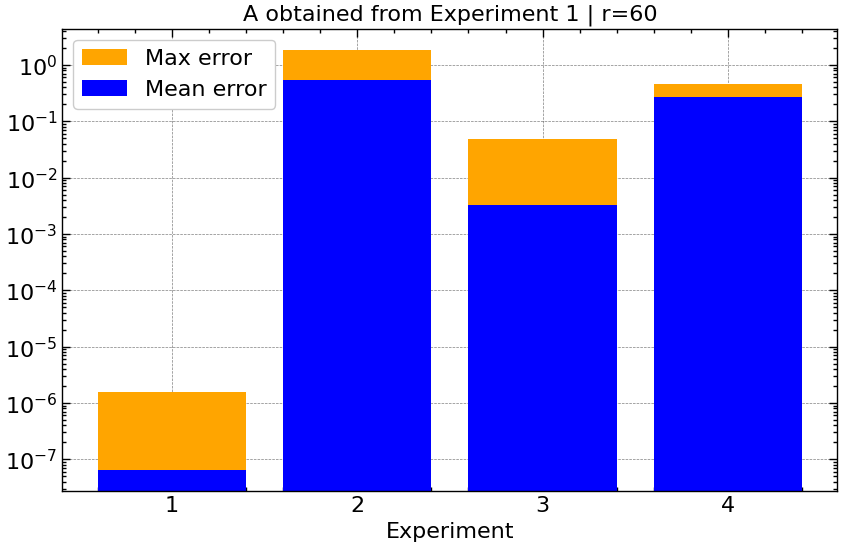

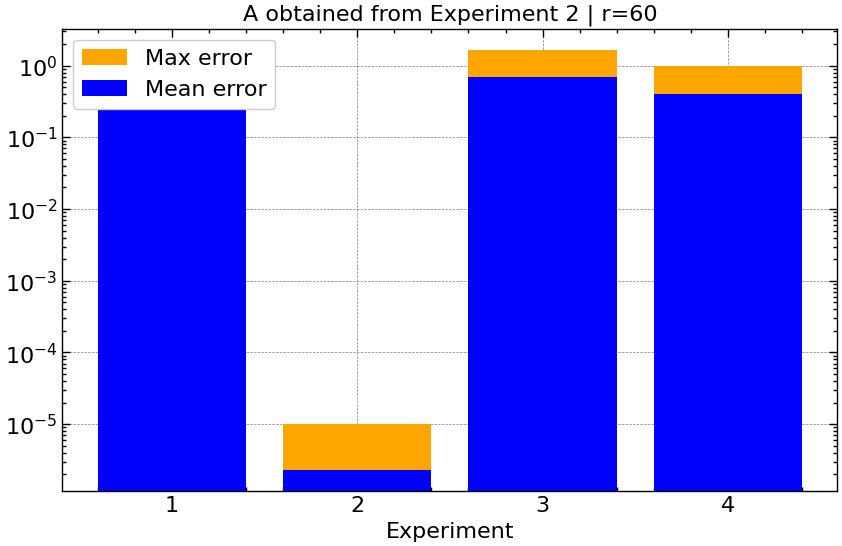

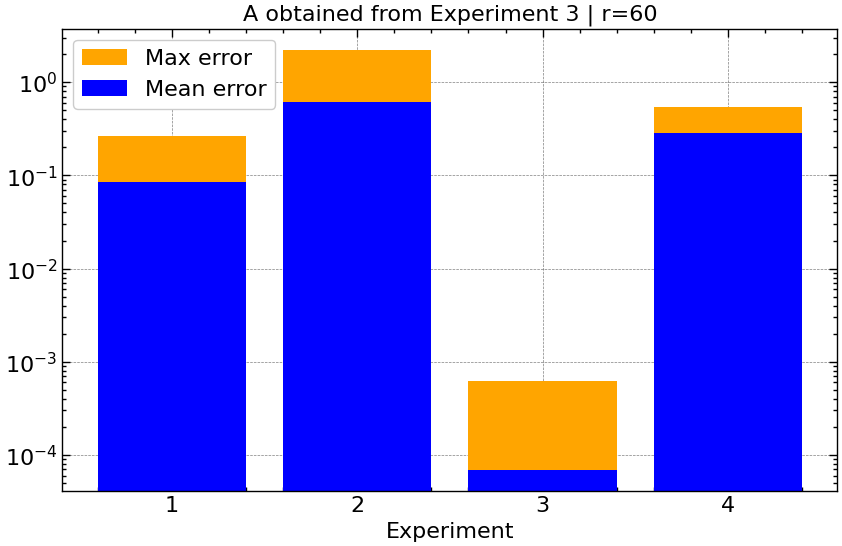

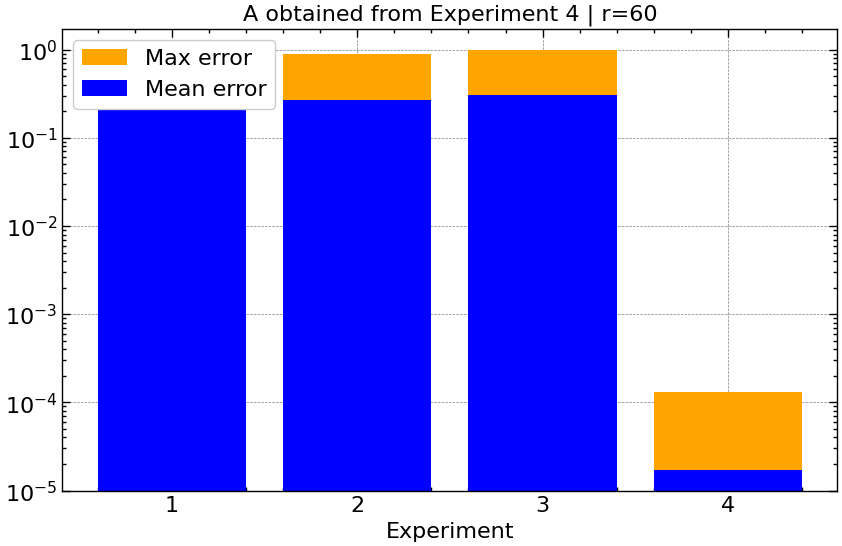

In [10]:
r = 60

X1,Y1 = D1[:,:-1], D1[:,1:]
A1 = DMD(X1, Y1, r=r)
MAE1, MAX1 = test_all_data(A1)
plot_bar(MAE1,MAX1,'A obtained from Experiment 1 | r=60')

X2,Y2 = D2[:,:-1], D2[:,1:]
A2 = DMD(X2, Y2, r=r)
MAE2, MAX2 = test_all_data(A2)
plot_bar(MAE2,MAX2,'A obtained from Experiment 2 | r=60')

X3,Y3 = D3[:,:-1], D3[:,1:]
A3 = DMD(X3, Y3, r=r)
MAE3, MAX3 = test_all_data(A3)
plot_bar(MAE3,MAX3,'A obtained from Experiment 3 | r=60')

X4,Y4 = D4[:,:-1], D4[:,1:]
A4 = DMD(X4, Y4, r=r)
MAE4, MAX4 = test_all_data(A4)
plot_bar(MAE4,MAX4,'A obtained from Experiment 4 | r=60')

### Train with a set of experiments

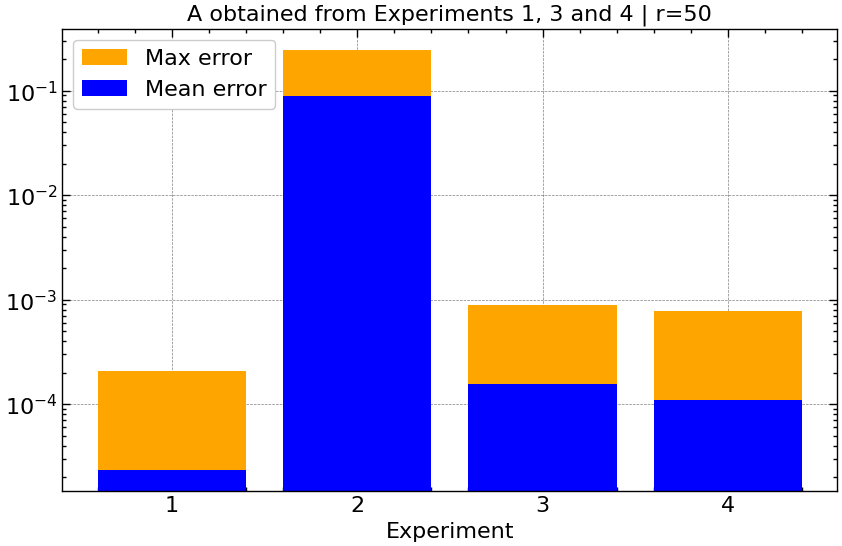

In [11]:
r = 50

X2_,Y2_ = np.concatenate([X1,X3,X4],axis=1), np.concatenate([Y1,Y3,Y4],axis=1)
A2_ = DMD(X2_, Y2_, r=r)
MAE2_, MAX2_ = test_all_data(A2_)
plot_bar(MAE2_,MAX2_,f'A obtained from Experiments 1, 3 and 4 | r={r}')

### Data reconstruction time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


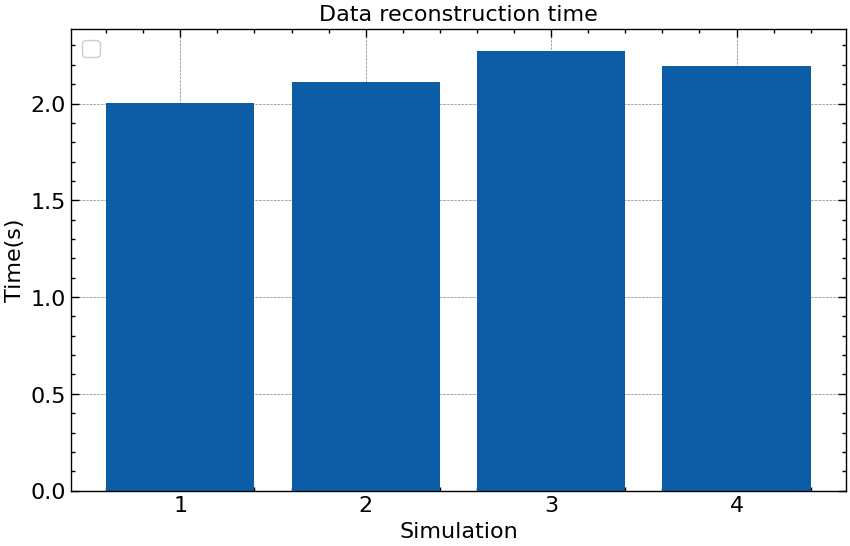

In [12]:
times = []
x = ['1','2','3','4']

Ds = [D1,D2,D3,D4]
As = []
Xs = []
Ys = []

for D in Ds:
    X,Y = D[:,:-1], D[:,1:]
    A = DMD(X, Y, r=r)
    Xs.append(X)
    Ys.append(Y)
    As.append(A)

for i,experiment in enumerate(x):
    start_time = time.time()
    D = Ds[i]
    D_pred = np.zeros(shape=(Nx,Nt)).astype(complex)
    D_pred[:,0] = D[:,0]
    A = As[i]

    for t in range(1,Nt):
        Xt = D_pred[:,t-1].reshape(Nx,1)
        Xt1 = A @ Xt
        Xt1
        D_pred[:,t] = Xt1.flatten()
    
    
    reconstruct_time = time.time() - start_time
    times.append(reconstruct_time)


plt.figure(figsize=(10,6))
plt.bar(x,times)
plt.xlabel('Simulation')
plt.ylabel('Time(s)')
plt.legend(loc='upper left')
plt.title('Data reconstruction time')
plt.show()